In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
import seaborn as sns
import numpy as np

In [15]:
data_folder = "../data"
train_file = "train_data.csv"
train_data = pd.read_csv(os.path.join(data_folder, train_file))
np.random.seed(2308723)
random_state = 84738

In [3]:
train_data.head()

,mu_ip,sigma_ip,kurtosis_ip,skewness_ip,mu_dmsnr,sigma_dmsnr,kurtosis_dmsnr,skewness_dmsnr,target
0,119.070312,54.464321,0.082501,-0.167191,0.617893,9.939801,19.553781,429.015329,0
1,89.687500,43.502110,0.437278,0.466080,5.973244,31.325766,5.831691,34.735606,0
2,108.765625,43.813612,0.251548,0.227560,2.653846,20.597689,8.887964,84.319531,0
3,76.492188,38.122745,0.750549,2.556619,3.250000,22.389197,7.711294,62.916367,0
4,97.007812,49.176579,0.574170,0.269369,104.935619,99.374734,0.053575,-1.779702,0


In [72]:
X_train = train_data.values[:, :-1]
y_train = train_data.values[:, -1]

In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
print(X_train.shape)
X_train_pca = pca.fit_transform(X_train)

(14318, 8)


In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

We'll compare linear and RBF SVM classifiers. Data didn't look linearly separable in data exploration so we expect RBF kernel to be better.

In [75]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
svc = SVC(random_state=random_state, max_iter=10000)
grid_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'class_weight': ["balanced", None], 
              'kernel': ['linear', 'rbf']}
svc = GridSearchCV(svc, grid_params, scoring=['f1_weighted', 'accuracy'], cv=5, refit='f1_weighted')
svc.fit(X_train_scaled, y_train)

C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma

C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.

C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ribau\Anaconda3\lib\site-pa

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf',
                           max_iter=10000, probability=False,
                           random_state=84738, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', None],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit='f1_weighted',
             return_train_score=False, scoring=['f1_weighted', 'accuracy'],
             verbose=0)

In [76]:
def dict_to_str(d):
    s = ""
    for key, item in d.items():
        s += f'{key}: {str(item)}; '
    return s

cv_res_df = pd.DataFrame()
cv_res_df['params'] = list(map(dict_to_str, svc.cv_results_['params']))
cv_res_df['mean_test_f1_weighted'] = svc.cv_results_['mean_test_f1_weighted']
cv_res_df['mean_test_accuracy'] = svc.cv_results_['mean_test_accuracy']

In [77]:
cv_res_df.sort_values(['mean_test_f1_weighted', 'mean_test_accuracy'], ascending=False).head(20)

,params,mean_test_f1_weighted,mean_test_accuracy
19,C: 10; class_weight: None; kernel: rbf;,0.979783,0.980305
23,C: 100; class_weight: None; kernel: rbf;,0.978945,0.979466
14,C: 1; class_weight: None; kernel: linear;,0.978598,0.979257
18,C: 10; class_weight: None; kernel: linear;,0.978450,0.979047
10,C: 0.1; class_weight: None; kernel: linear;,0.977629,0.978419
15,C: 1; class_weight: None; kernel: rbf;,0.977589,0.978279
13,C: 1; class_weight: balanced; kernel: rbf;,0.975729,0.975276
11,C: 0.1; class_weight: None; kernel: rbf;,0.975418,0.976463
8,C: 0.1; class_weight: balanced; kernel: linear;,0.975398,0.974997
27,C: 1000; class_weight: None; kernel: rbf;,0.975244,0.975904


Turns out RBF is better than linear kernel, but only very very slightly. Weighted classes seems to be consistently worse than no weights. Extreme values for C are worse than C being around 1 or 10

In [78]:
svc_clf = svc.best_estimator_

In [79]:
svc.best_score_

0.9797826333097601

In [80]:
predictions = svc_clf.predict(X_train_scaled)

In [99]:
def results(predictions, targets):
    def compare(x, y):
        if x == 1 and y == 1:
            return "true positive"
        elif x == 0 and y == 0:
            return "true negative"
        elif x == 1 and y == 0:
            return "false positive"
        else: 
            return "false negative"
    func = np.vectorize(compare)
    return func(predictions, targets)

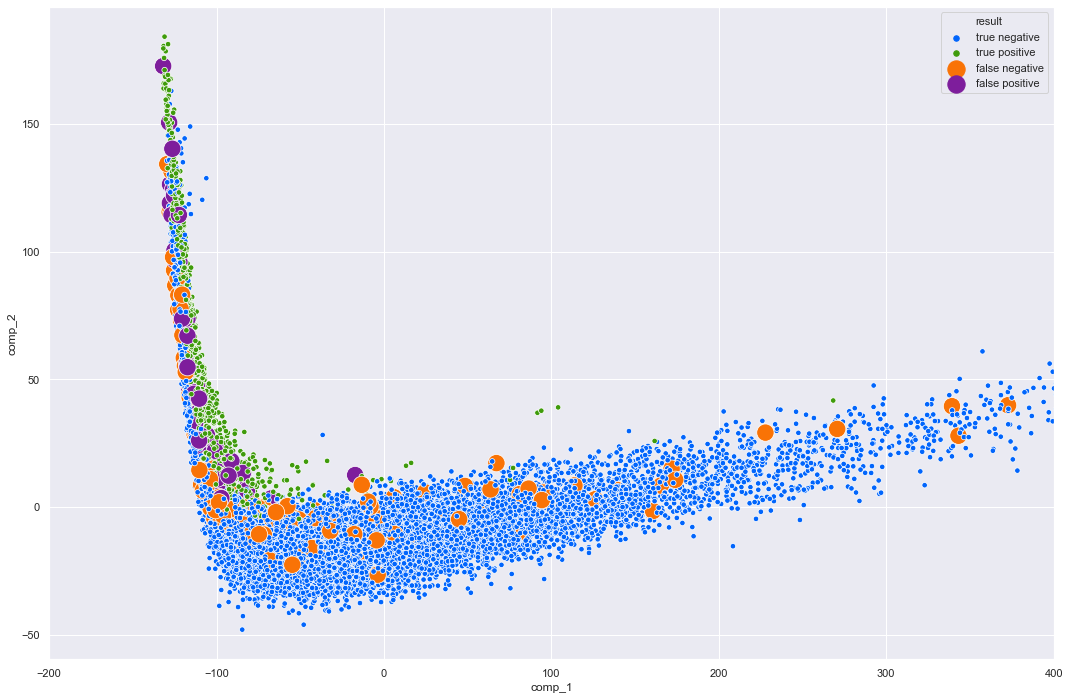

In [109]:
def plot_results_2d(predictions):
    results_df = pd.DataFrame()
    results_df["comp_1"] = X_train_pca[:, 0]
    results_df["comp_2"] = X_train_pca[:, 1]
    results_df["result"] = results(predictions, y_train)

    sns.set(rc={'figure.figsize':(18, 12)})
    colors = ["bright blue", "grass green", "orange", "purple"]
    my_palette = list(map(lambda x: sns.xkcd_rgb[x], colors))
    sns.scatterplot(x="comp_1", y="comp_2", hue="result", size="result",
                    sizes=[30, 30, 300, 300], palette=my_palette, data=results_df)
    plt.xlim(-200, 400);
    
plot_results_2d()

In [69]:
sum(predictions)

1167.0

In [70]:
sum(y_train)

1311.0